In [5]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
data = pd.read_csv("https://raw.githubusercontent.com/CompPhysVienna/MLSummerSchoolVienna2022/main/Day01_July11/data/qm7.csv")
X = data.values[:, :-1]
y = data.values[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=6000)

mean energy: -1537.4 kcal/mol
mean energy: 223.4 kcal/mol


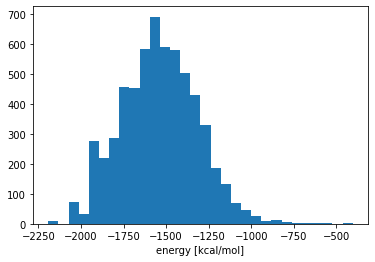

In [7]:
plt.hist(y_train, bins=30)
plt.xlabel("energy [kcal/mol]")
y_mean, y_scale = np.mean(y_train), np.std(y_train)
print(f"mean energy: {y_mean:.1f} kcal/mol")
print(f"mean energy: {y_scale:.1f} kcal/mol")

In [12]:
def calculate_features(X):
  X = X.reshape([-1, 23, 23])
  features = jnp.linalg.eigvalsh(X) # length 23
  return features

def model(params, X):
  features = calculate_features(X)
  y = neural_network(params, features)
  y = y * y_scale + y_mean
  return y.flatten()


def neural_network(params, X):
  # params: [ (w1, b1), (w2, b2), ...]
  for ind_layer, (w, b) in enumerate(params):
    X = X @ w + b   # @ = matmul
    if ind_layer == (len(params) - 1):
      pass
    else:
      X = jax.nn.relu(X)
  return X

def init_params_for_neural_network(input_dim, output_dim, n_hidden_neurons):
  input_dims = [input_dim] + n_hidden_neurons
  output_dims = n_hidden_neurons + [output_dim]
  params = []
  for i,o in zip(input_dims, output_dims):
    b = np.zeros(o)
    w = np.random.normal(size=[i, o], scale=2/(i+o)) # glorot initializers
    params.append((w,b))
  return params


def loss_func(params, X, y):
  y_pred = model(params, X)
  residual = (y_pred - y) / y_scale
  return jnp.mean(residual**2)

n_hidden_neurons = [50, 50]
n_epochs = 500
batch_size = 50
learning_rate = 1e-3

@jax.jit
def training_step(params, x, y):
    loss, grad = jax.value_and_grad(loss_func, argnums=0)(params, x, y)
    def update_params(p, g):
      return p - g * learning_rate
    params = jax.tree_map(update_params, params, grad)
    return loss, params

def make_batches(X, y, batch_size):
  ind = np.random.permutation(len(X))
  X = X[ind]
  y = y[ind]
  n_batches = len(X) // batch_size
  for n in range(n_batches):
    yield X[n*batch_size : (n+1) * batch_size], y[n*batch_size : (n+1) * batch_size]

@jax.jit
def evaluate_model_accuracy(params):
  y_pred_train = model(params, X_train)
  y_pred_test = model(params, X_test)
  mae_train = jnp.mean(jnp.abs(y_pred_train - y_train))                                 # mean absolute error#
  mae_test = jnp.mean(jnp.abs(y_pred_test - y_test))
  return y_pred_train, y_pred_test, mae_train, mae_test

params = init_params_for_neural_network(23, 1, n_hidden_neurons)

loss_values = []
mae_train_values = []
mae_test_values = []
for n in range(n_epochs):
  for x, y in make_batches(X_train, y_train, batch_size):
    loss, params = training_step(params, x, y)
    loss_values.append(loss)
  y_pred_train, y_pred_test, mae_train, mae_test = evaluate_model_accuracy(params)
  mae_train_values.append(mae_train)
  mae_test_values.append(mae_test)
  print(f"n_epoch={n}, mae_train={mae_train:0f}, mae_test={mae_test:0f}")


n_epoch=0, mae_train=174.225266, mae_test=178.331497
n_epoch=1, mae_train=170.176651, mae_test=173.974289
n_epoch=2, mae_train=165.000214, mae_test=168.718964
n_epoch=3, mae_train=159.373962, mae_test=163.309982
n_epoch=4, mae_train=151.279266, mae_test=154.049820
n_epoch=5, mae_train=138.459793, mae_test=140.641022
n_epoch=6, mae_train=130.661346, mae_test=131.778351
n_epoch=7, mae_train=138.931763, mae_test=140.159729
n_epoch=8, mae_train=128.471085, mae_test=128.778839
n_epoch=9, mae_train=128.201172, mae_test=128.658539
n_epoch=10, mae_train=120.170006, mae_test=119.800911
n_epoch=11, mae_train=119.453384, mae_test=119.140961
n_epoch=12, mae_train=129.064606, mae_test=129.713852
n_epoch=13, mae_train=119.193665, mae_test=118.024597
n_epoch=14, mae_train=129.103958, mae_test=129.882935
n_epoch=15, mae_train=115.742455, mae_test=115.052979
n_epoch=16, mae_train=116.486565, mae_test=115.979752
n_epoch=17, mae_train=134.486374, mae_test=136.288116
n_epoch=18, mae_train=114.020645, mae_

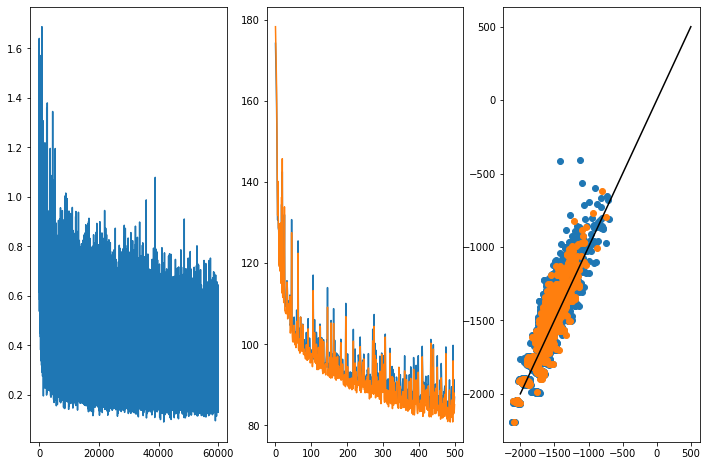

In [16]:
fig, axes = plt.subplots(1,3, figsize=(12,8))
axes[0].plot(loss_values)

axes[1].plot(mae_train_values, label="Train")
axes[1].plot(mae_test_values, label="Test")

axes[2].scatter(y_pred_train, y_train, label="Train")
axes[2].scatter(y_pred_test, y_test, label="Test")
axes[2].plot([-2000, 500], [-2000, 500], color='k')